In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from ase.visualize import view
from ase.visualize.plot import plot_atoms
# from ase.build import graphene
from ase.io import read, write
from ase.atoms import Atoms


## Requires `seaborn` to be installed!!!
import seaborn as sb
sb.set_theme("notebook", "darkgrid")


from ase.spacegroup import crystal # Useful for setting up crystals

In [2]:
# Helper functions
def sort_atoms(atoms):
    # Use numpy.lexsort to sort by z, then y, then x
    pos = atoms.get_positions()
    sorted_indices = np.lexsort((pos[:, 2], pos[:, 1], pos[:, 0]))
    return atoms[sorted_indices]

def print_matrix(V):
    """
    Print the hopping matrix with row and column indices for better readability.
    
    Parameters:
        V: np.ndarray
            The N x N hopping matrix to print.
    """
    N = V.shape[0]
    # Print column headers
    header = "   " + " ".join(f"{j:8d}" for j in range(N))
    print(header)
    print("-" * len(header))
    
    # Print each row with row index and formatted values
    for i in range(N):
        row_values = " ".join(f"{V[i, j]:8.2f}" for j in range(N))
        print(f"{i:<3d} {row_values}")

## Define system

In [252]:
a0 = 3.9 # Angstrom
oxide = crystal("SrVO3", basis=[[0.5,0.5,0.5], [0.,0.,0.], [0.5,0.,0.]], cellpar=a0, spacegroup=221) 
# Notice, only need to specify 1 oxygen atom the other oxygen sites are determined by spacegroup (221 in this case)

<Axes: >

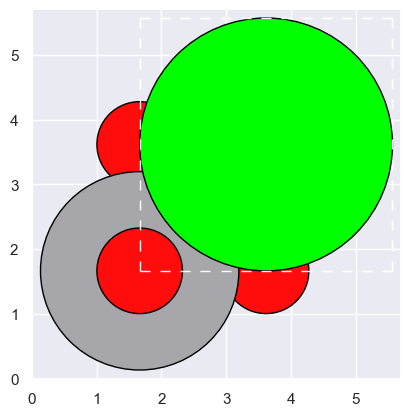

In [253]:
plot_atoms(oxide)


# Throw away atoms to simplify Hamiltonian

In [254]:
oxide = oxide[[atom.index for atom in oxide if atom.symbol=='V']] # Only keep vanadium (i.e., B site)
init_oxide_copy = oxide.copy()

In [6]:
view(oxide)

<Popen: returncode: None args: ['c:\\Users\\basti\\anaconda3\\envs\\10325\\p...>

### Save figure

In [7]:
write("oxide.xyz", oxide)

### For playing with the number of atoms per unit cell

array([[0., 0., 0.]])

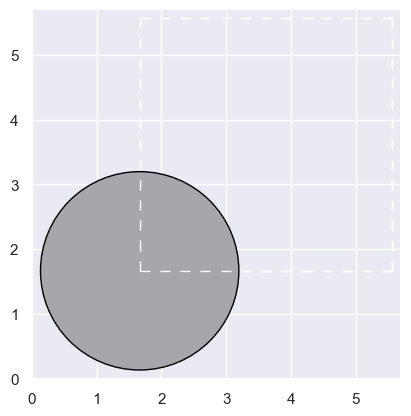

In [256]:
thickness = 1
oxide = read("oxide.xyz")
oxide = oxide.repeat((1,thickness,1))
# oxide.center(vacuum=15, axis=1)
plot_atoms(oxide)
xyz = oxide.get_positions()
xyz


## Some important functions for determining the matrix elements -- will be used later

In [ ]:
def oop_distance(coor1, coor2):
    return np.abs(coor1[None, :] - coor2[:, None])

def distance(xyz1, xyz2):
    return np.linalg.norm(xyz1[None, :, :] - xyz2[:, None, :], axis=2)

def hamiltonian(xyz1, xyz2, lower, upper, plane=True):
    """Compute "hamiltonian" by determining where the inter-atomic distance is within ranges
    Parameters
    ---
    xyz1 : ndarray of shape `(K, 3)`
        Array of the coordinates for the atoms.
    xyz2 : ndarray of shape `(K, 3)`
        Anoter array for the coordinates of atoms. usually equal to `xyz1`
    lower : float
        Lower range for determining valid distances
    upper : float
        Upper range for determining valid distances
    plane : bool, optional
        Usually boolean array for which atmos are in the same plane.
        
    Returns
    ---
    arr : ndarray of shape `(K,K)`
        1's where `lower < distances < upper` and `plane`evalueates to `True`,
        and 0's otherwise
    """
    dist = distance(xyz1, xyz2)
    return np.where( (lower < dist) & (dist < upper ) & plane, 1, 0)


def get_H(atoms, orbital):
    """Compute H for an extended system
    Parameters
    ---
    atoms : ase.Atoms, ndarray of shape `(K, 3)`
        Takes an `Atoms` object or the xyz coordinates of the `K` atoms
    orbital : str
        Takes values for the 3 different orbitals: `dxy`, `dyz`, or `dxz`
    
    Returns
    ---
    H : ndarray of shape `(K,K)` for the hopping of the extended system
    """
    
    a = 3.9
    eps = 0.6
    t_ip = -0.3
    t_oop = -0.03
    t_diag = -0.1
    num_atoms = len(atoms)
    H = np.identity(num_atoms) * eps # diagonal elements are the on-sites
    
    # some error handling. 
    if isinstance(atoms, Atoms): # check if `atoms` is an `ase.Atoms`` object
        xyz = atoms.get_positions()
    elif isinstance(atoms, np.ndarray): # check if `atoms` is a numpy array (ndarray)
        xyz = atoms
    else:
        raise AttributeError(f"atoms input has to be of type `ndarray` or `ase.Atoms`, but was {type(atoms)}")
    
    ## Use the `orbital` arg to determine which xyz coordinate corresponds to out-of-plane (oop)
    if orbital == "dxy":
        coords = xyz[:, 2] # z is oop
    elif orbital == "dyz":
        coords = xyz[:, 0] # x is oop
    elif orbital == "dxz":
        coords = xyz[:, 1] # y is oop
    else:
        raise AttributeError(f"Orbital: `{orbital}` is not a valid input")
    
    # compute distance for the oop coordinates
    oop_diff = oop_distance(coords,  coords)
    # create boolean mask (True/False array) for which atoms are in the same plane
    same_plane = (oop_diff == 0)
    # boolean mask for which atoms are in different planes (the oop-direction)
    different_plane = (~same_plane) # using the element-wise NOT operator "~"
    H += hamiltonian(xyz, xyz, 0.1, a+0.1, same_plane) * t_ip  # within bond-length and same-plane is the hop in-plane 
    H += hamiltonian(xyz, xyz, 0.1, a+0.1, different_plane) * t_oop # within bond-length but in different planes is the hop out-of-plane
    H += hamiltonian(xyz, xyz, 0.1+a, np.sqrt(2)*a+0.1, same_plane) * t_diag # within diagonal of same-plane
    return H

#### test on some system -- sanity check
test = oxide.repeat((1,5,1))
test.center(vacuum=15, axis=1)
test = test.repeat((2,1,1))
view(test)
out = get_H(test.get_positions(), "dyz")
print_matrix(out)

# print_matrix(out[len(out)//2:, len(out)//2:])
# print_matrix(out[:len(out)//2, :len(out)//2])

          0        1        2        3        4        5        6        7        8        9
--------------------------------------------------------------------------------------------
0       0.60    -0.30     0.00     0.00     0.00    -0.03     0.00     0.00     0.00     0.00
1      -0.30     0.60    -0.30     0.00     0.00     0.00    -0.03     0.00     0.00     0.00
2       0.00    -0.30     0.60    -0.30     0.00     0.00     0.00    -0.03     0.00     0.00
3       0.00     0.00    -0.30     0.60    -0.30     0.00     0.00     0.00    -0.03     0.00
4       0.00     0.00     0.00    -0.30     0.60     0.00     0.00     0.00     0.00    -0.03
5      -0.03     0.00     0.00     0.00     0.00     0.60    -0.30     0.00     0.00     0.00
6       0.00    -0.03     0.00     0.00     0.00    -0.30     0.60    -0.30     0.00     0.00
7       0.00     0.00    -0.03     0.00     0.00     0.00    -0.30     0.60    -0.30     0.00
8       0.00     0.00     0.00    -0.03     0.00     0.00     

In [244]:
def get_PBC_ham(struct, k_vec, orbital):
    """Compute H for a system that *might* not be periodic in some direction
    
    Parameters
    ---
    struct : ase.Atoms object of `N` atoms
        The structure to look at. If it has high vacuum in along some axis, then no hopping will be allowed.
    k_vec : ndarray of shape `(K, 3)`
        The kx, ky, kz values to use when computing the hamiltonian
    orbital : str
        The orbital. Possible values `dxy`, `dyz`, `dxz`
    
    Returns
    ---
    ham : ndarray of shape `(K, N, N)`
        For each value of kx, ky, kz the hamiltonian is calculated
    """
    kx, ky, kz = k_vec.T
    kx = kx[:, None, None]
    ky = ky[:, None, None]
    kz = kz[:, None, None]
    
    # define on-site
    x_extend = struct.repeat((2,1,1)) 
    num_atoms = len(x_extend)
    N = num_atoms //2 # elements to index for the h and V matrices (is reused)
    Hx = get_H(x_extend, orbital)
    
    y_extend = struct.repeat((1,2,1))
    Hy = get_H(y_extend, orbital)
    
    z_extend = struct.repeat((1,1,2))
    Hz = get_H(z_extend, orbital)
    # num_atoms = len(y_extend)
    ##
    ##              1          2
    ##         |   h    ,   V^dagger    |     1
    ##   H =   |                        |
    ##         |   V    ,      h        |     2
    ##
    hx = Hx[:N, :N] # first row, first column
    Vx = Hx[N:, :N] # second row, first column # hopping for in x
    
    # hy = Hy[:N, :N]
    Vy = Hy[N:, :N] # hopping in y
    
    # hz = Hz[:N, :N]
    Vz = Hz[N:, :N] # hopping in z
    
    # compute the PBC hamiltonian
    ham = Vx*np.exp(2j*np.pi*kx) + Vy*np.exp(2j*np.pi*ky) + Vz*np.exp(2j*np.pi*kz)
    ham += np.transpose(np.conj(ham), axes=(0, 2, 1)) + hx
    
    # print("hx")
    # print_matrix(hx)
    # print()
    # print("Vx")
    # print_matrix(Vx)
    # print()
    # print("hy")
    # print_matrix(hy)
    # print()
    # print("Vy")
    # print_matrix(Vy)
    # print()
    # print("hz")
    # print_matrix(hz)
    # print()
    # print("Vz")
    # print_matrix(Vz)
    
    return ham

def PBC_bandstructure(atoms, k_vec, orbital):
    
    HAM = get_PBC_ham(atoms, k_vec, orbital)
    return np.linalg.eigvalsh(HAM)
    
    
X = (0.5, 0,   0)
G = (0,   0,   0)
M = (0.5, 0.5, 0)
kpoints = 5
tmp1 = np.linspace(X, G, endpoint=False, num=kpoints)
tmp2 = np.linspace(G, M, num=kpoints)
k_vec = np.concatenate((tmp1, tmp2), axis=0)
# k_vec
eigs = PBC_bandstructure(oxide, k_vec, "dxy")
eigs.shape

(10, 1)

# Task: Set up <u>slab</u> Hamiltonian and calculate band structure

From the slab geometry, construct Hamiltonians and calculate band structures. The major difference is that the states at the top/bottom surfaces of the slabs have no states to couple to. Implement this breaking of periodicity.

Note: keep periodic boundary conditions in the two other directions!

Study and understand the band structure. What is the role of the thickness?

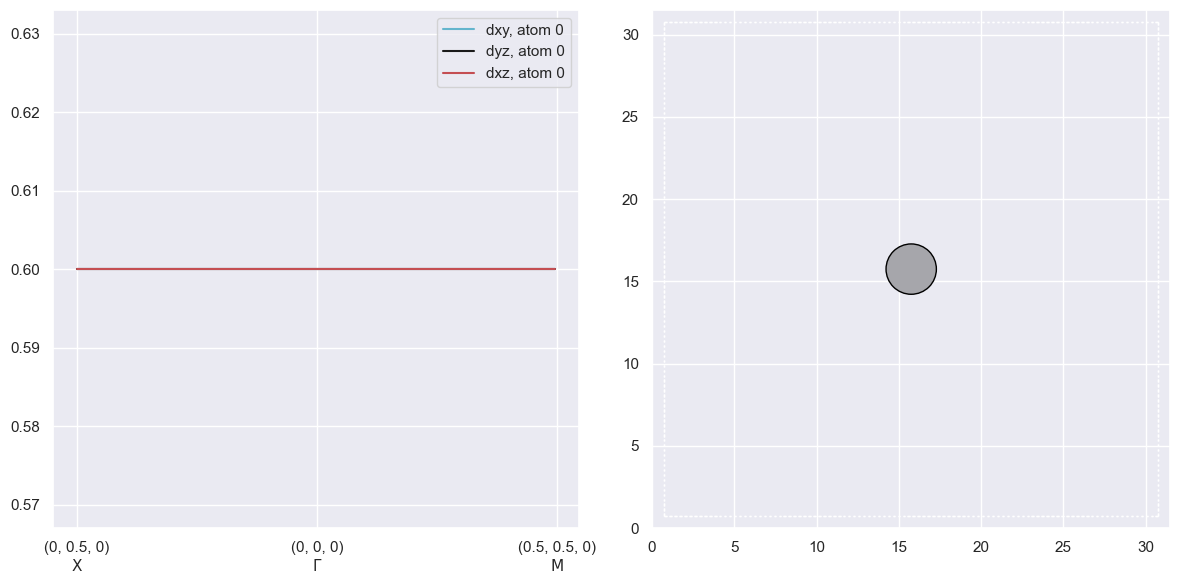

In [257]:
X = (0      , 0.5   , 0) # define X symmetry point
G = (0      , 0     , 0) # define GAMMA symmetry point
M = (0.5    , 0.5   , 0) # define M symmetry point
kpoints = 101 # number of k value to use
tmp1 = np.linspace(X, G, endpoint=False, num=kpoints) # from X -> G (excluding G to avoid double counting) : ndarray of shape (kpoints, 3) 
tmp2 = np.linspace(G, M, num=kpoints) # from G -> M : ndarray of shape (kpoints, 3)
k_vec = np.concatenate((tmp1, tmp2), axis=0) # combine path X -> G -> M : ndarray of shape (2*kpoints, 3)

# system to investigate 
thickness = 1 # number of atoms to use
test = read("oxide.xyz") # read backup file
test = test.repeat((1,thickness, 1)) # repeat in y direction. Thickness allows the atoms not on the edge to be periodic. Combine with vacuum below to break edge periodicity

### Break PBC in a direction by setting vacuum "length" (Angstrom, Å) in the direction
## Using all three completely isolates the atom, and therefore no periodicity or movement of the elctron allowed
test.center(vacuum=15, axis=0) # add vacuum along x to break PBC along x-axis.
test.center(vacuum=15, axis=1) # add vacuum along y to break PBC along y-axis.
test.center(vacuum=15, axis=2) # add vacuum along z to break PBC along z-axis.


fig, axes = plt.subplots(1,2, figsize=(12,6))
plot_atoms(test, ax=axes[1]) # plot atoms on the right
l_style=["-", "--", ":", "-.", "-", "--"] # must have entries according to number of atoms
colors = ["c", "k", "r"] # number of orbitals

for idx, orb in enumerate(["dxy", "dyz", "dxz"]): # iterate orbitals
    eigs = PBC_bandstructure(test, k_vec, orb) # compute eigenvalues for orbital
    for i, eig in enumerate(eigs.T):        # iterate each atom for said orbital
        axes[0].plot(eig, label=orb + f", atom {i}", color=colors[idx], linestyle=l_style[i])
        

# legend and labels
axes[0].legend()
axes[0].set(xticks=(0, len(eig)//2, len(eig)),
       xticklabels=[f"{X}\n"+r"$\mathrm{X}$", f"{G}\n"+r"$\Gamma$", f"{M}\n"+r"$\mathrm{M}$"])

# figure restraint -- for a neat finish
fig.tight_layout()

# Task: Transport in pristine bulk and slabs

Now that you can construct Hamiltonians and the band structures make sense, you can calculate the $\vec{k}$ and energy-resolved transmission as in the lecture notes/exercises.

Start with bulk systems and evaluate $T(E, k_x, k_y)$ with transport in $z$-direction.

Then continue with slabs and evaluate $T(E, k_x)$ with transport in $z$-direction and normal of slab along the $y$-axis.